In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import sys
print(sys.executable)

/home/nathan/miniconda3/envs/milk/bin/python


In [1]:
from __future__ import print_function
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import sys
import os
import glob

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)
from sklearn.metrics import (cohen_kappa_score, confusion_matrix, classification_report, f1_score)

# For permutation tests
from sympy.utilities.iterables import multiset_permutations

from MulticoreTSNE import MulticoreTSNE as MTSNE

# sys.path.insert(0, '../tfmodels/')
# import tfmodels

# sys.path.insert(0, '../svs_reader')
# from normalize import reinhard
from svs_reader import reinhard

# config = tf.ConfigProto( device_count = {'GPU': 0} )

# colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
# labels = ['G3', 'G4', 'G5', 'BN', 'ST']
colors = [ '#af2108', '#149104', '#0ebbeb', '#0366a3']
labels = ['G3', 'G4/5', 'BN', 'ST']

In [2]:
colors = np.array([[239, 188, 57], # Orange
                   [198, 27, 27],  # Red
#                    [198, 27, 27],  # Red
                   [11, 147, 8], # Green
                   [80, 81, 80],# Gray
                   [0,0,0],
                  ]) / 255.

In [3]:
def get_input_output_ops(sess, model_path):
    input_key = 'image'
    output_key = 'prediction'
    print('Loading model {}'.format(model_path))
    signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
    meta_graph_def = tf.saved_model.loader.load(
        sess,
        [tf.saved_model.tag_constants.SERVING],
        model_path )
    signature = meta_graph_def.signature_def

    print('Getting tensor names:')
    image_tensor_name = signature[signature_key].inputs[input_key].name
    print('Input tensor: ', image_tensor_name)
    predict_tensor_name = signature[signature_key].outputs[output_key].name
    print('Output tensor:', predict_tensor_name)

    image_op = sess.graph.get_tensor_by_name(image_tensor_name)
    predict_op = sess.graph.get_tensor_by_name(predict_tensor_name)
    print('Input:', image_op.get_shape())
    print('Output:', predict_op.get_shape())
    return image_op, predict_op


In [4]:
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'; MODULE_NAME='InceptionV3'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'; MODULE_NAME='NasNet'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'; MODULE_NAME='Resnet50'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/1'; MODULE_NAME='Resnet101'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'; MODULE_NAME='Resnet152'
MODULE_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/feature_vector/1'; MODULE_NAME='MobilenetV2'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/1'; MODULE_NAME='InceptionResnet'

# config = tf.ConfigProto( device_count = {'GPU': 0} )
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# module = hub.Module(MODULE_URL)
# height, width = hub.get_expected_image_size(module)
# print(height, width)
# image_in = tf.placeholder('float', [1, height, width, 3])
# z_op = module(image_in)
# sess.run(tf.global_variables_initializer())

MODULE_PATH = '../tfhub/snapshots/mobilenet_v2_050_224'
image_in, predict_op = get_input_output_ops(sess, MODULE_PATH)
_, height, width, _ = image_in.get_shape()



Loading model ../tfhub/snapshots/mobilenet_v2_050_224
INFO:tensorflow:Restoring parameters from ../tfhub/snapshots/mobilenet_v2_050_224/variables/variables
Getting tensor names:
Input tensor:  Placeholder:0
Output tensor: final_result:0
Input: (?, 224, 224, 3)
Output: (?, 5)


## Populate a matrix of feature vectors

And run the classifier on images

In [5]:
# jpg_list = sorted(glob.glob('../data/jpg/*.jpg'))
# mask_list = sorted(glob.glob('../data/mask/*.png'))

jpg_list = sorted(glob.glob('../data/val_jpg_ext/*.jpg'))
mask_list = sorted(glob.glob('../data/val_mask_ext/*.png'))

img_plotting = {}
img_classes = []
orig_imgs = []

z_vectors = []
y_vectors = []
idx = 0

# resize = 1.
resize = 0.5
# resize = 0.25
crop_size = int(height * (1/resize))

samples = 7
x0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
    x = reinhard(x)
#     x = cv2.imread(jpg, -1)
               
    for k in range(samples):
#         x0 = np.random.randint(0, 1200-crop_size)
#         y0 = np.random.randint(0, 1200-crop_size)
        x0 = x0_vect[k]
        y0 = y0_vect[k]
        
        ## Grab the majority label
        y_ = y[x0:x0+crop_size, y0:y0+crop_size]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        # Check for majority
        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (crop_size**2):
            # check for stroma -- two ways to skip stroma
            if maj==4 and totals[maj] < 0.95 * (crop_size*2):
                continue
#             elif maj==4 and np.random.randn(1) < 0.5:
#             elif maj==4 and np.random.choice([0,1], p=[0.1, 0.9]):
#                 continue
        else:
            continue

        img_classes.append(maj)
        orig_imgs.append(img_idx)
        
        idx += 1
        if idx % 500 == 0:
            print('{} [{} / {}]'.format(idx, img_idx, len(jpg_list)))
        x_ = x[x0:x0+crop_size, y0:y0+crop_size, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=resize, fy=resize)
        x_ = x_ * (1/255.)
        x_ = np.expand_dims(x_, 0)
        
        # With low probability save an image for annotation
        if np.random.randn() < -2:
            img_plotting[idx] = x_
        
        ## Toggle between classification and z-manifold calculation
        yhat = sess.run(predict_op, feed_dict={image_in: x_.astype(np.float32)})
        y_vectors.append(yhat)
        
#         z = sess.run(z_op, feed_dict={image_in: x_})
#         z_vectors.append(z)

# z_vectors = np.concatenate(z_vectors, axis=0)
# print('z vectors', z_vectors.shape)
# manifold = MTSNE(n_jobs=8, n_components=2, verbose=1)
# z_manifold = manifold.fit_transform(z_vectors)
# print('z manifold', z_manifold.shape)
# np.save('mobilenet_z_manifold', z_manifold)

print('Done')

500 [77 / 538]
1000 [149 / 538]
1500 [221 / 538]
2000 [293 / 538]
2500 [364 / 538]
3000 [438 / 538]
3500 [510 / 538]
Done


In [7]:
img_classes = np.asarray(img_classes)
print('img classes', img_classes.shape)

img classes (3672,)


## Classifier stuff

In [8]:
z_manifold = np.load('mobilenet_z_manifold.npy')
y_vectors = np.concatenate(y_vectors, axis=0)
# y_vectors = y_vectors.reshape(len(img_classes), 4)
print(z_manifold.shape)
print(y_vectors.shape)

(3672, 2)
(3672, 5)


In [9]:
ymax = np.argmax(y_vectors, axis=-1)
ymax[ymax==2] = 1
ymax[ymax==3] = 2
ymax[ymax==4] = 3
img_classes[img_classes==2] = 1
img_classes[img_classes==3] = 2
img_classes[img_classes==4] = 3
for k in range(4):
    print((ymax==k).sum())
    
accuracy = np.mean(img_classes == ymax)
print(accuracy)

549
1081
738
1304
0.6944444444444444


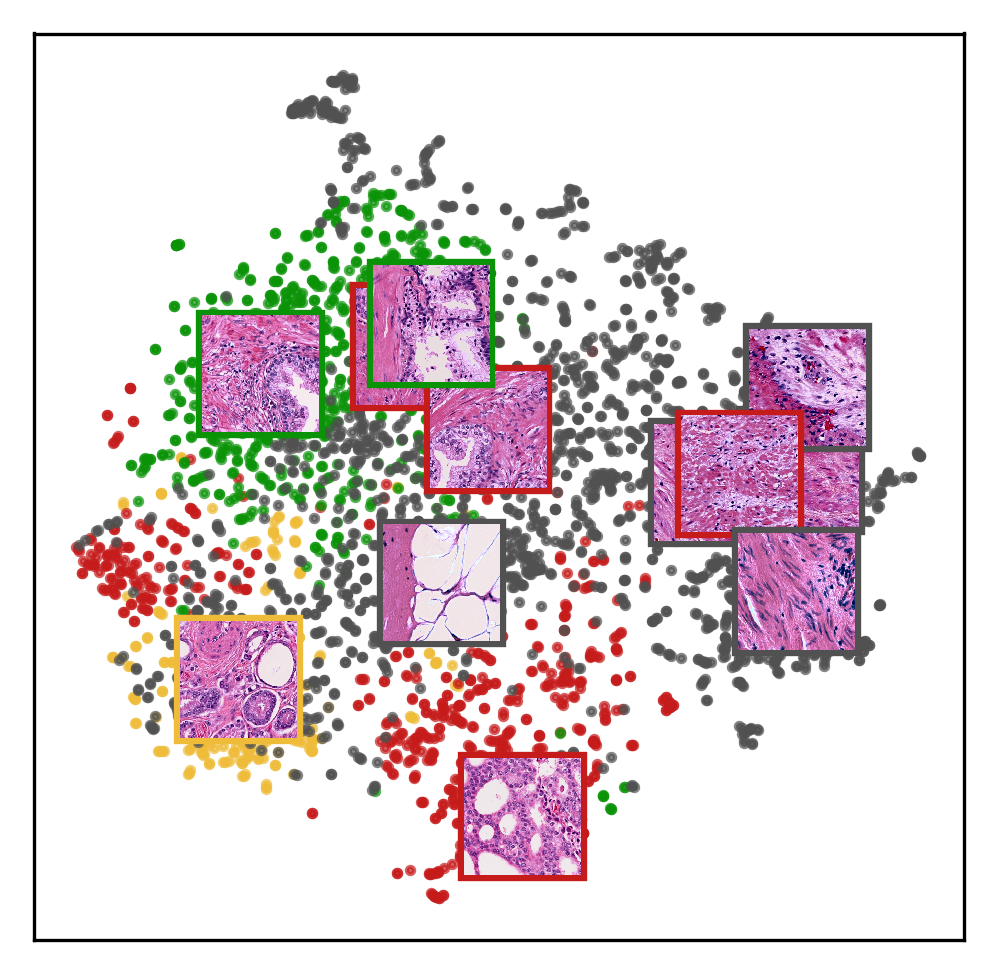

In [38]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=300)
for k in range(4):
#     idx = ymax==k
    idx = img_classes==k
#     sns.regplot(z_manifold[idx,0], z_manifold[idx,1], color=colors[k], label=labels[k],
#                 fit_reg=False, scatter_kws={'alpha': 0.7})
    plt.scatter(z_manifold[idx,0], z_manifold[idx,1], color=colors[k], label=labels[k],
                alpha=0.7, s=3)
    
# plt.title('MobileNet 75%', fontsize=32)
plt.xticks([])
plt.yticks([])
# plt.legend(fontsize=36)

artists = []
indices = [k for k in img_plotting.keys()]
np.random.shuffle(indices)
for k in indices[:12]:
    img_ = img_plotting[k]
    x,y = z_manifold[k]
    im = OffsetImage(np.squeeze(img_), zoom=0.125)
    ab = AnnotationBbox(im, (x,y), xycoords='data', pad=0.05, frameon=True,
                        bboxprops={'ec': colors[ymax[k]], 'lw': 2})
    artists.append(ax.add_artist(ab))
    
plt.savefig('MobileNet_img.png', bbox_inches='tight')

## Cluter the z vectors

In [7]:
# Compare label assignments with the annotation
# clustered = clusterer.labels_

max_kappa = 0.0
max_f1 = 0.0
best_remapped = None

for vers in range(10):
    clusterer = MiniBatchKMeans(n_clusters=5, verbose=0, n_init=100).fit(z_vectors)
    clustered = clusterer.labels_
    
    for perm in multiset_permutations(range(5)):
        # Pick a mapping clustered --> labels
        mapping = {x: k for x, k in zip(range(5), perm)}

        clustered_remapped = np.asarray([mapping[y] for y in clustered])

        kappa = cohen_kappa_score(img_classes, clustered_remapped)
        f1 = f1_score(img_classes, clustered_remapped, average='weighted')
# 
#         print(vers, f1, max_f1)
#         if kappa > max_kappa:
        if f1 > max_f1:
            best_remapped = clustered_remapped
            max_kappa = kappa
            max_f1 = f1
            print(vers, kappa, f1)
            print(mapping)
            print(classification_report(img_classes, clustered_remapped), end='\n\n')

0 0.14800520023566188 0.341795503393631
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
             precision    recall  f1-score   support

          0       0.04      0.05      0.04       461
          1       0.56      0.33      0.41      1344
          2       0.29      0.45      0.36       546
          3       0.21      0.19      0.20       361
          4       0.49      0.77      0.60       323

avg / total       0.38      0.34      0.34      3035


0 0.1919576597308129 0.3529341834664095
{0: 1, 1: 0, 2: 2, 3: 3, 4: 4}
             precision    recall  f1-score   support

          0       0.22      0.37      0.28       461
          1       0.61      0.26      0.36      1344
          2       0.29      0.45      0.36       546
          3       0.21      0.19      0.20       361
          4       0.49      0.77      0.60       323

avg / total       0.43      0.36      0.35      3035


0 0.18973024205612765 0.365813006180646
{0: 2, 1: 1, 2: 0, 3: 3, 4: 4}
             precision    recall  f1-

Text(0.5,0.98,'Resnet152 (resize=1.0)\nf1=0.438')

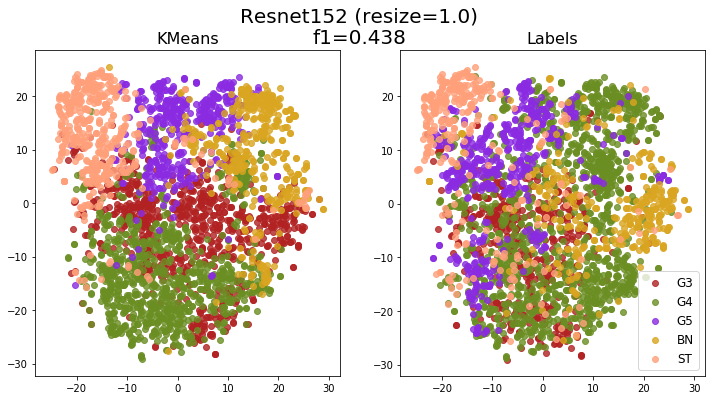

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

for k in range(5):
    idxs = np.where(best_remapped==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], ax=axs[0])
    
    idxs = np.where(img_classes==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k], ax=axs[1])

axs[0].set_title('KMeans', fontsize=16)
axs[1].set_title('Labels', fontsize=16)
plt.legend(fontsize=12)
# plt.suptitle(u'{}\n$\kappa={:3.3f}$'.format(MODULE_NAME, max_kappa), fontsize=20)
plt.suptitle('{} (resize={})\nf1={:3.3f}'.format(MODULE_NAME, resize, max_f1), fontsize=20)
# plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_kmeans.pdf'.format(MODULE_NAME), bbox_inches='tight')